In [1]:
# call __init_ to set notebook seed
import set_notebook_env
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utils.modeling_helpers import ModelHelper
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA


from collections import defaultdict
import numpy as np

import set_notebook_env
loader, plot_utils = set_notebook_env.set_env(
    data_dir="../data/", 
    min_ratings=0, 
    max_ratings=None,
    drop_inconsistent_gender = True
)

SEED = np.random.get_state()[1][0]

loader.initial_setup()
loader.add_tag_intensity_score()
prepared_df = loader.add_gender_code(loader.prepared_df)
TAG_COLS = loader.tag_cols
prepared_df.columns

tag_intensity_score = loader.find_agg_tag_columns("tag_intensity_score")
loader.add_column_zscores_standardized(columns = tag_intensity_score)
ZSCORE_COLS = loader.find_agg_tag_columns("zscore_tag_intensity_")

prepared_df = loader.prepared_df

MODEL_HELPER = ModelHelper(df=prepared_df, random_seed=SEED)
NUM_COLS = loader.num_cols


Using seed: 18787288


In [2]:
pepper_counts = prepared_df["pepper"].value_counts()
pepper_props = prepared_df["pepper"].value_counts(normalize=True)

pepper_counts, pepper_props


(pepper
 0.0    37662
 1.0    14426
 Name: count, dtype: int64,
 pepper
 0.0    0.723046
 1.0    0.276954
 Name: proportion, dtype: float64)

In [3]:
for col in NUM_COLS + ZSCORE_COLS:
    print(f"{col} : {prepared_df[col].isna().sum()}")
    
# remove NAs
tag_cols = [
    c for c in NUM_COLS
    if not any(g in c.lower() for g in ["would_take_again_prop", "female", "male"])
]


# has online rating 
prepared_df["has_online_ratings"] = np.where(
    prepared_df["num_online_ratings"] > 0, 1, 0
)

d = prepared_df[tag_cols + ["has_online_ratings"] + ZSCORE_COLS]\
    .drop("num_online_ratings", axis = 1)



avg_rating : 0
avg_difficulty : 0
num_ratings : 0
pepper : 0
would_take_again_prop : 43239
num_online_ratings : 0
male : 0
female : 0
zscore_tag_intensity_score_tough_grader : 0
zscore_tag_intensity_score_good_feedback : 0
zscore_tag_intensity_score_respected : 0
zscore_tag_intensity_score_lots_to_read : 0
zscore_tag_intensity_score_participation_matters : 0
zscore_tag_intensity_score_no_skip : 0
zscore_tag_intensity_score_lots_of_hw : 0
zscore_tag_intensity_score_inspirational : 0
zscore_tag_intensity_score_pop_quizzes : 0
zscore_tag_intensity_score_accessible : 0
zscore_tag_intensity_score_papers : 0
zscore_tag_intensity_score_clear_grading : 0
zscore_tag_intensity_score_hilarious : 0
zscore_tag_intensity_score_test_heavy : 0
zscore_tag_intensity_score_few_things : 0
zscore_tag_intensity_score_amazing_lectures : 0
zscore_tag_intensity_score_caring : 0
zscore_tag_intensity_score_extra_credit : 0
zscore_tag_intensity_score_group_projects : 0
zscore_tag_intensity_score_lecture_heavy : 0

In [4]:
summary = d[ZSCORE_COLS].agg(
    ["min", "mean", "median", "max", "std", "var"]
).T

summary


,min,mean,median,max,std,var
zscore_tag_intensity_score_tough_grader,-0.590150,-1.309555e-16,-0.590150,6.293888,1.00001,1.000019
zscore_tag_intensity_score_good_feedback,-0.786770,-3.983230e-17,-0.439986,5.455351,1.00001,1.000019
zscore_tag_intensity_score_respected,-0.602783,3.355735e-17,-0.602783,7.145010,1.00001,1.000019
zscore_tag_intensity_score_lots_to_read,-0.531550,5.129091e-17,-0.531550,7.333831,1.00001,1.000019
zscore_tag_intensity_score_participation_matters,-0.624780,3.710406e-17,-0.624780,6.620672,1.00001,1.000019
zscore_tag_intensity_score_no_skip,-0.559741,-9.494274e-17,-0.559741,11.657652,1.00001,1.000019
zscore_tag_intensity_score_lots_of_hw,-0.530166,7.311682e-17,-0.530166,7.206727,1.00001,1.000019
zscore_tag_intensity_score_inspirational,-0.456122,-6.636443e-17,-0.456122,9.063490,1.00001,1.000019
zscore_tag_intensity_score_pop_quizzes,-0.236886,-1.909768e-18,-0.236886,16.036886,1.00001,1.000019
zscore_tag_intensity_score_accessible,-0.360619,4.692572e-17,-0.360619,7.267617,1.00001,1.000019


In [5]:
baseline_acc = max(pepper_props)
baseline_acc

0.7230456151128859

In [6]:
print(prepared_df.groupby("pepper")["avg_rating"].describe())
print(prepared_df.groupby("pepper")["avg_difficulty"].describe())
print(prepared_df.groupby("pepper")["num_ratings"].describe())


          count      mean       std  min  25%  50%  75%  max
pepper                                                      
0.0     37662.0  3.632056  1.183605  1.0  2.9  4.0  4.6  5.0
1.0     14426.0  4.403993  0.633389  1.0  4.1  4.5  4.9  5.0
          count      mean       std  min  25%  50%  75%  max
pepper                                                      
0.0     37662.0  2.924659  1.039825  1.0  2.0  3.0  3.7  5.0
1.0     14426.0  2.641585  0.817121  1.0  2.0  2.7  3.2  5.0
          count      mean        std  min  25%  50%  75%    max
pepper                                                         
0.0     37662.0  4.244384   6.094009  1.0  1.0  2.0  5.0  286.0
1.0     14426.0  7.917094  11.127984  1.0  3.0  5.0  9.0  393.0


In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

Y = d["pepper"].astype(float).astype(int)
X = d.drop(columns=["pepper"]).select_dtypes(include=["number"])

print(type(Y), Y.shape)
print(Y.value_counts())

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "f1": "f1",
    "bal_acc": "balanced_accuracy"
}

res = cross_validate(pipe, X, Y, cv=cv, scoring=scoring, return_train_score=False)

for k, v in res.items():
    if k.startswith("test_"):
        print(k, np.mean(v), np.var(v), np.std(v))


<class 'pandas.core.series.Series'> (52088,)
pepper
0    37662
1    14426
Name: count, dtype: int64
test_roc_auc 0.7758929876320055 2.614253133683905e-05 0.00511297675887922
test_pr_auc 0.5480325594186802 2.5892477676548017e-05 0.005088465159215303
test_f1 0.3991416402059491 8.083408952417874e-05 0.008990778026632553
test_bal_acc 0.611959587637798 1.4544794677868254e-05 0.0038137638466308127


In [8]:
from sklearn.metrics import precision_recall_curve
import numpy as np

y_proba = cross_val_predict(
    pipe, X, Y, cv=cv, method="predict_proba"
)[:, 1]

precision, recall, thresholds = precision_recall_curve(Y, y_proba)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx - 1]

best_threshold

0.27821647602762445

In [9]:
target_recall = 0.80
idx = np.where(recall >= target_recall)[0][-1]
threshold_recall_80 = thresholds[idx - 1]
threshold_recall_80



0.24777442179460696

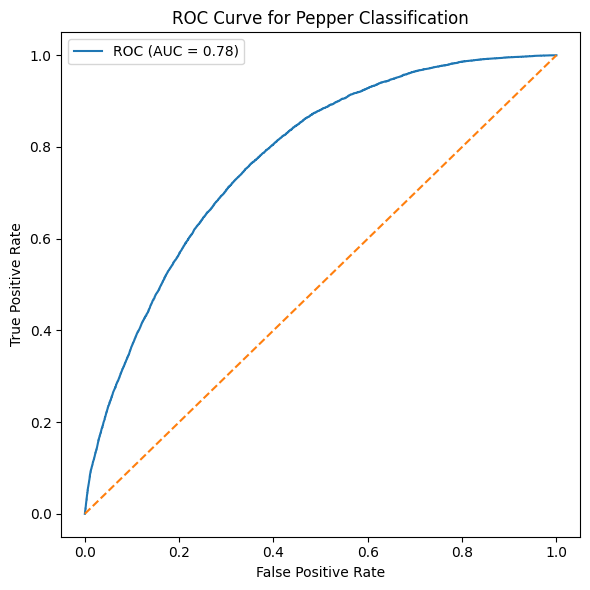

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, roc_thresh = roc_curve(Y, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Pepper Classification")
plt.legend()
plt.tight_layout()
plt.show()


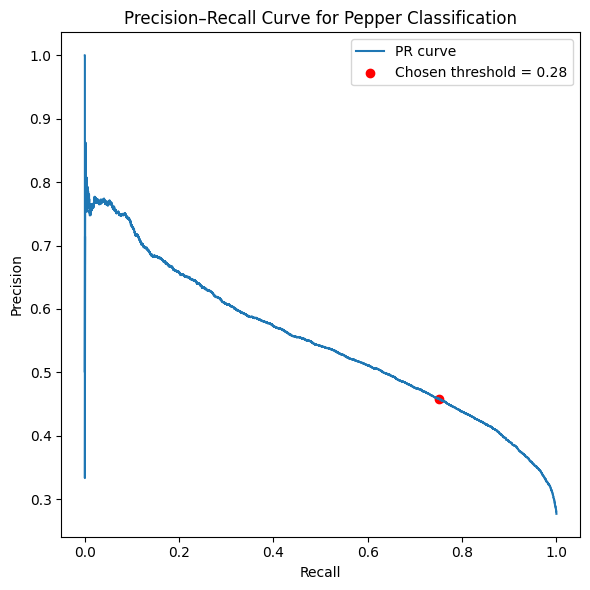

In [11]:
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label="PR curve")

plt.scatter(
    recall[best_idx],
    precision[best_idx],
    color="red",
    label=f"Chosen threshold = {best_threshold:.2f}"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve for Pepper Classification")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    accuracy_score, balanced_accuracy_score
)

def metrics_at_threshold(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    metrics = {
        "threshold": threshold,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "specificity": tn / (tn + fp) if (tn + fp) else np.nan,
        "fpr": fp / (fp + tn) if (fp + tn) else np.nan,
        "fnr": fn / (fn + tp) if (fn + tp) else np.nan,
    }
    return cm, metrics


In [13]:
from sklearn.model_selection import cross_val_predict

y_proba = cross_val_predict(pipe, X, Y, cv=cv, method="predict_proba")[:, 1]

cm_05, m_05 = metrics_at_threshold(Y, y_proba, threshold=0.5)
cm_opt, m_opt = metrics_at_threshold(Y, y_proba, threshold=best_threshold)

print("CM @ 0.5:\n", cm_05)
print(m_05)

print("\nCM @ best threshold:\n", cm_opt)
print(m_opt)


CM @ 0.5:
 [[34911  2751]
 [10142  4284]]
{'threshold': 0.5, 'tn': 34911, 'fp': 2751, 'fn': 10142, 'tp': 4284, 'accuracy': 0.7524765780986024, 'balanced_accuracy': 0.6119596836743598, 'precision': 0.608955223880597, 'recall': 0.29696381533342575, 'f1': 0.3992358231210102, 'specificity': 0.9269555520152939, 'fpr': 0.07304444798470607, 'fnr': 0.7030361846665742}

CM @ best threshold:
 [[24830 12832]
 [ 3577 10849]]
{'threshold': 0.27821647602762445, 'tn': 24830, 'fp': 12832, 'fn': 3577, 'tp': 10849, 'accuracy': 0.6849754262018123, 'balanced_accuracy': 0.705665070037141, 'precision': 0.4581309910899033, 'recall': 0.752044918896437, 'f1': 0.569396698769255, 'specificity': 0.659285221177845, 'fpr': 0.34071477882215495, 'fnr': 0.247955081103563}
